In [1]:
import os
import math
import numpy as np

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt
from matplotlib import lines
from matplotlib import colors
import sys

from base import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Parameters.
SAVE_FIGS = True

model_type = 'opengmm'

datasets = 'Vaihingen'
if '_' in datasets:
    datasets = datasets.split('_')
else:
    datasets = [datasets]

architectures = 'unet'
if '_' in architectures:
    architectures = architectures.split('_')
else:
    architectures = [architectures]

reg_covars = '0.0001'
if '_' in reg_covars:
    reg_covars = reg_covars.split('_')
else:
    reg_covars = [reg_covars]

n_comps = ['4']

epoch = 1200

unk_classes = '0'
if '_' in unk_classes:
    unk_classes = unk_classes.split('_')
else:
    unk_classes = [unk_classes]
    
segments = 'fz_slic03_mean_50'
if '__' in segments:
    segments = segments.split('__')
else:
    segments = [segments]

open_clip_value = 4000
min_pixels=50
dataset_path='../datasets/'


In [3]:
def post_process(img, segmentation, segment_name, distance = 'mean'):
    if 'median' in segment_name:
        distance='median'
    loaded = np.load(segmentation)
    segments = loaded['arr_0']
    new_img = np.zeros(img.shape)
    max_segment = np.max(segments)+2
    for i in range(0,max_segment):
        cond = segments==i
        new_img[cond]=np.mean(img[cond])
        if distance=='mean':
            new_img[cond]=np.mean(img[cond])
        else:
            new_img[cond]=np.median(img[cond])
    total_segments = np.max(loaded['arr_0']) + (1 if np.min(loaded['arr_0'])==0 else 0)
    return new_img, total_segments

Vaihingen unet unet_Vaihingen_opengmm_dsm_50_0.0001_4 fz_slic03_mean_50
Unk: 0
     top_mosaic_09cm_area11
     top_mosaic_09cm_area15
     top_mosaic_09cm_area28
     top_mosaic_09cm_area30
     top_mosaic_09cm_area34
FIM Vaihingen unet unet_Vaihingen_opengmm_dsm_50_0.0001_4 fz_slic03_mean_50


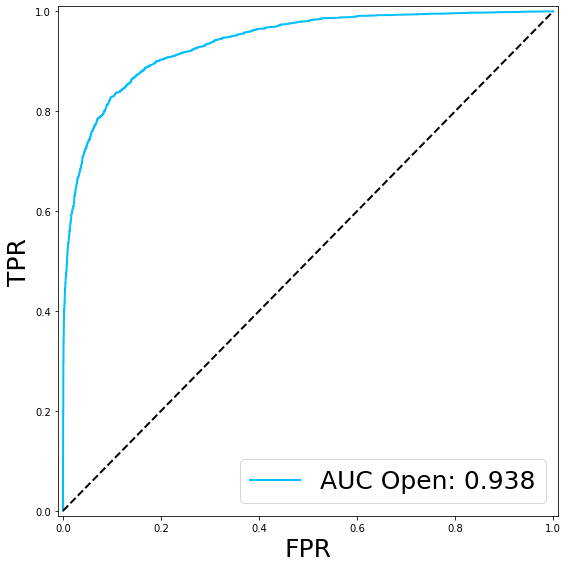

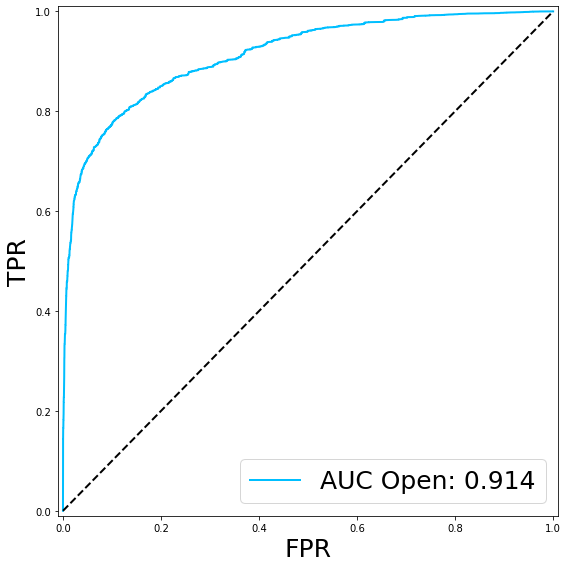

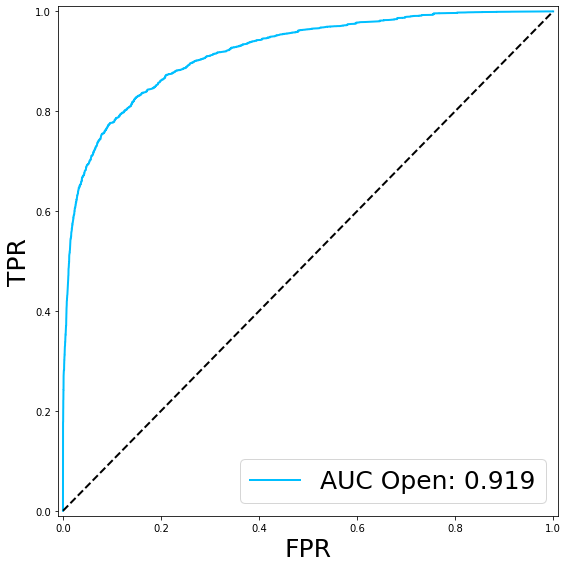

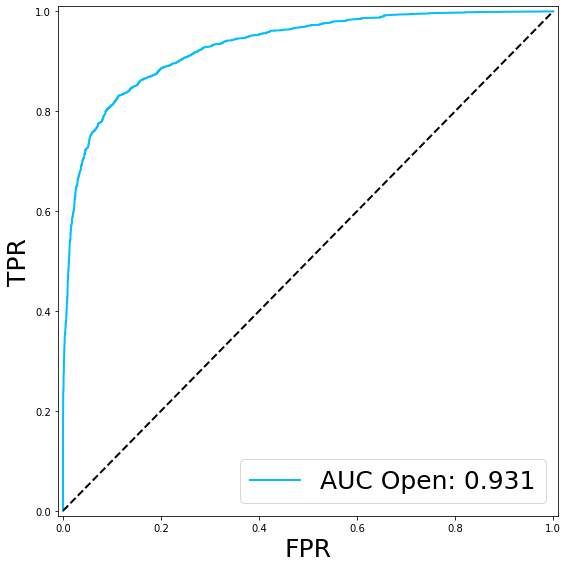

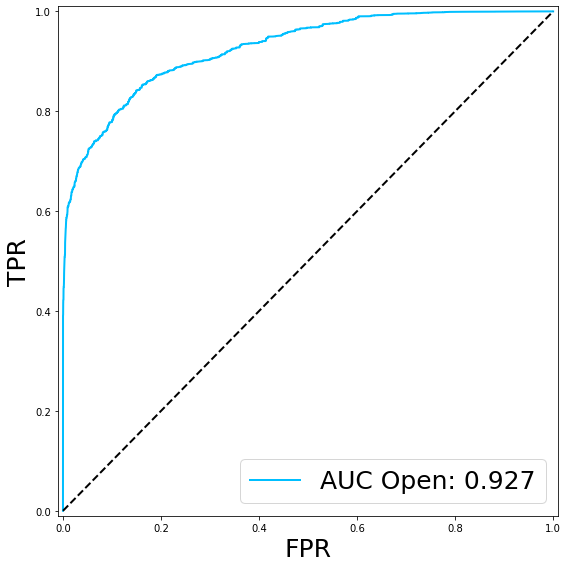

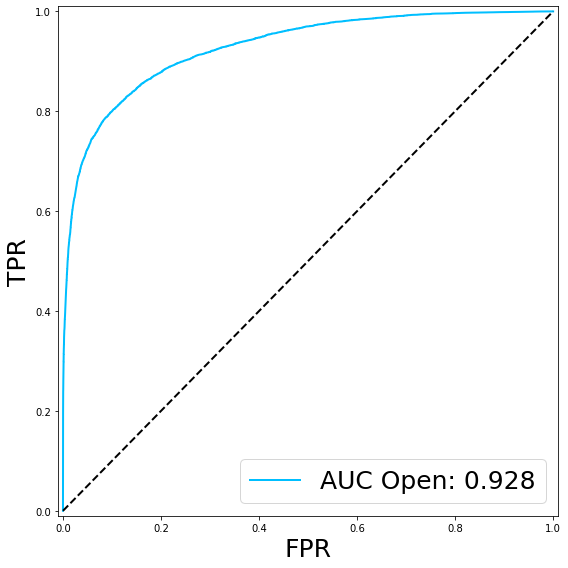

In [4]:
for dataset in datasets:

    for architecture in architectures:

        exp_group_base = architecture + '_' + dataset + '_' + model_type + '_dsm_'+str(min_pixels)
        for reg_covar in reg_covars:

            for n_components in n_comps:

                exp_group = exp_group_base+'_'+reg_covar+'_'+n_components

                for unk_class in unk_classes:
                    
                    for segment in segments:

                        print(dataset, architecture, exp_group, segment)
                        if '_' in unk_class:
                            n_known = 4 - len(unk_class.split('_'))
                        else:
                            n_known = 4

                        print('Unk: %s' % (unk_class))

                        # Computing directories.
                        base_dir = './outputs/%s_%s_base_dsm_%s/epoch_%d/' % (architecture, dataset, unk_class, epoch)
                        open_dir = './outputs/%s/%s_%s_%s_dsm_%s/epoch_%d/' % (exp_group, architecture, dataset, model_type, unk_class, epoch)

                        base_output = './superpixel/qualitative/%s/%s/' % (exp_group, segment)
                        if not os.path.isdir(base_output):
                            os.makedirs(base_output)

                        output_dir = './superpixel/qualitative/%s/%s/full_dsm_%s_%s_%s/' % (exp_group, segment, architecture, dataset, unk_class)
                        if not os.path.isdir(output_dir):
                            os.makedirs(output_dir)

                        # Presetting plot colors.
                        if unk_class == '0':
                            classes = ['', 'Building', 'Grass', 'Tree', 'Car', 'Unknown (Street)']
                        elif unk_class == '1':
                            classes = ['', 'Street', 'Grass', 'Tree', 'Car', 'Unknown (Building)']
                        elif unk_class == '2':
                            classes = ['', 'Street', 'Building', 'Tree', 'Car', 'Unknown (Grass)']
                        elif unk_class == '3':
                            classes = ['', 'Street', 'Building', 'Grass', 'Car', 'Unknown (Tree)']
                        elif unk_class == '4':
                            classes = ['', 'Street', 'Building', 'Grass', 'Tree', 'Unknown (Car)']
                        elif unk_class == '0_1':
                            classes = ['', 'Grass', 'Tree', 'Car', 'Unknown (Street, Building)']
                        elif unk_class == '1_4':
                            classes = ['', 'Street', 'Grass', 'Tree', 'Unknown (Building, Car)']
                        elif unk_class == '2_3':
                            classes = ['', 'Street', 'Building', 'Car', 'Unknown (Grass, Tree)']
                        elif unk_class == '0_1_4':
                            classes = ['', 'Grass', 'Tree', 'Unknown (Street, Building, Car)']

                        cmap_list = []

                        msk_leg = []
                        for i in range(1, n_known + 2):
                            rgba_curr = None
                            if 'Street' == classes[i]:
                                rgba_curr = (1.0, 1.0, 1.0, 1.0)
                            elif 'Building' == classes[i]:
                                rgba_curr = (0.0, 0.0, 1.0, 1.0)
                            elif 'Grass' == classes[i]:
                                rgba_curr = (0.0, 1.0, 1.0, 1.0)
                            elif 'Tree' == classes[i]:
                                rgba_curr = (0.0, 1.0, 0.0, 1.0)
                            elif 'Car' == classes[i]:
                                rgba_curr = (1.0, 1.0, 0.0, 1.0)
                            if 'Unknown' in classes[i]:
                                rgba_curr = (1.0, 0.0, 0.0, 1.0)
                            msk_leg.append(lines.Line2D([0], [0], marker='s', label=classes[i], markerfacecolor=rgba_curr, markersize=10))
                            cmap_list.append(rgba_curr)

                        rgba_curr = (0.0, 0.0, 0.0, 1.0)
                        msk_leg.append(lines.Line2D([0], [0], marker='s', label='Boundaries', markerfacecolor=rgba_curr, markersize=10))
                        cmap_list.append(rgba_curr)

                        prd_leg = []
                        for i in range(1, n_known + 2):
                            rgba_curr = None
                            if 'Street' == classes[i]:
                                rgba_curr = (1.0, 1.0, 1.0, 1.0)
                            elif 'Building' == classes[i]:
                                rgba_curr = (0.0, 0.0, 1.0, 1.0)
                            elif 'Grass' == classes[i]:
                                rgba_curr = (0.0, 1.0, 1.0, 1.0)
                            elif 'Tree' == classes[i]:
                                rgba_curr = (0.0, 1.0, 0.0, 1.0)
                            elif 'Car' == classes[i]:
                                rgba_curr = (1.0, 1.0, 0.0, 1.0)
                            if 'Unknown' in classes[i]:
                                rgba_curr = (1.0, 0.0, 0.0, 1.0)
                            prd_leg.append(lines.Line2D([0], [0], marker='s', label=classes[i], markerfacecolor=rgba_curr, markersize=10))

                        cmap_msk = colors.ListedColormap(cmap_list)
                        cmap_prd = colors.ListedColormap(cmap_list[:-1])

                        # Iterating over images.
                        if dataset == 'Vaihingen':
                            full_samples = [
                                'top_mosaic_09cm_area11',
                                'top_mosaic_09cm_area15',
                                'top_mosaic_09cm_area28',
                                'top_mosaic_09cm_area30',
                                'top_mosaic_09cm_area34',
                            ]

                            full_patches = [
                                (23, 17),
                                (23, 17),
                                (23, 17),
                                (23, 17),
                                (23, 13),
                            ]
                        else:
                            full_samples = [
                                'top_potsdam_2_11_IRRG',
                                'top_potsdam_2_12_IRRG',
                                'top_potsdam_4_10_IRRG',
                                'top_potsdam_5_11_IRRG',
                                'top_potsdam_6_7_IRRG',
                                'top_potsdam_7_8_IRRG',
                                'top_potsdam_7_10_IRRG'
                            ]

                            full_patches = [
                                (53, 53),
                                (53, 53),
                                (53, 53),
                                (53, 53),
                                (53, 53),
                                (53, 53),
                                (53, 53)
                            ]

                        scr_open_all = []
                        msk_all = []
                        
                        cm_all = [np.zeros((n_known+1, n_known+1), dtype=np.int16) for i in range(11)]
                        total_segments = 0
                        for full_sample, full_patch in zip(full_samples, full_patches):
                            metric_base_path = './superpixel/metrics/%s/%s/' % (exp_group, segment)
                            if not os.path.isdir(metric_base_path):
                                os.makedirs(metric_base_path)

                            out_open_path = './superpixel/metrics/%s/%s/%s_%s_%s_%s_dsm_open.txt' % (exp_group, segment, full_sample, architecture, dataset, unk_class)
                            roc_output_path = './superpixel/metrics/%s/%s/%s_%s_%s_%s_dsm_auc.pdf' % (exp_group, segment, full_sample, architecture, dataset, unk_class)

                            print('    ', full_sample)

                            full_img = np.zeros(((full_patch[0] + 1) * (224 // 2), (full_patch[1] + 1) * (224 // 2), 3), dtype=np.uint8)
                            full_dsm = np.zeros(((full_patch[0] + 1) * (224 // 2), (full_patch[1] + 1) * (224 // 2)), dtype=np.uint8)
                            full_msk = np.zeros(((full_patch[0] + 1) * (224 // 2), (full_patch[1] + 1) * (224 // 2)), dtype=np.uint8)

                            full_scr_open = np.zeros((
                                (full_patch[0] + 1) * (224 // 2),
                                (full_patch[1] + 1) * (224 // 2)
                            ), dtype=np.float32)
                            full_prd_closed = np.zeros((
                                (full_patch[0] + 1) * (224 // 2),
                                (full_patch[1] + 1) * (224 // 2),
                                4
                            ), dtype=np.uint8)

                            full_msk[:] = 5
                            full_prd_closed[:] = 5

                            for y in range(full_patch[0]):

                                for x in range(full_patch[1]):

                                    f = full_sample + '_img_' + str(y) + '_' + str(x) + '.png'

                                    # Setting paths.
                                    image_path = os.path.join(base_dir, f)
                                    label_path = os.path.join(base_dir, f.replace('_img_', '_tru_'))

                                    open_scr_path = os.path.join(open_dir, f.replace('_img_', '_scor_').replace('.png', '.npy'))

                                    # Loading images.
                                    img = io.imread(image_path)
                                    msk = io.imread(label_path)

                                    scr_open = np.load(open_scr_path)

                                    # Computing Priors.
                                    full_img[y*112:y*112+224, x*112:x*112+224, :] = img[:,:,:3]
                                    full_dsm[y*112:y*112+224, x*112:x*112+224] = img[:,:,-1]
                                    full_msk[y*112:y*112+224, x*112:x*112+224] = msk

                                    notnan_open = ~np.isnan(scr_open)

                                    # tenho que ver se eh util para o gmm
                                    scr_open = np.clip(scr_open, -open_clip_value, open_clip_value)

                                    full_scr_open[y*112:y*112+224, x*112:x*112+224][notnan_open] += scr_open[notnan_open]

                                    if not np.all(notnan_open):
                                        print('Open patch (%d,%d) has NaNs' % (y, x))

                            for over_idx in range(4):

                                if over_idx == 0:
                                    y_offset = 0
                                    x_offset = 0
                                elif over_idx == 1:
                                    y_offset = 0
                                    x_offset = 112
                                elif over_idx == 2:
                                    y_offset = 112
                                    x_offset = 0
                                elif over_idx == 3:
                                    y_offset = 112
                                    x_offset = 112

                                for y in range(full_patch[0]):

                                    for x in range(full_patch[1]):

                                        f = full_sample + '_img_' + str(y) + '_' + str(x) + '.png'

                                        # Setting paths.
                                        open_prd_path = os.path.join(open_dir, f.replace('_img_', '_prev_'))

                                        # Loading images.
                                        prd_open = io.imread(open_prd_path)

                                        # Computing Priors.
                                        pri_open = np.copy(prd_open)

                                        # Computing Posteriors according to thresholds.
                                        if over_idx == 0:
                                            y_full_offset = y*112
                                            x_full_offset = x*112
                                        elif over_idx == 1:
                                            y_full_offset = y*112
                                            x_full_offset = x*112 + 112
                                        elif over_idx == 2:
                                            y_full_offset = y*112 + 112
                                            x_full_offset = x*112
                                        elif over_idx == 3:
                                            y_full_offset = y*112 + 112
                                            x_full_offset = x*112 + 112

                                        full_prd_closed[y_full_offset:y_full_offset+112, x_full_offset:x_full_offset+112, over_idx] = pri_open[y_offset:y_offset+112, x_offset:x_offset+112]
                            
                            full_scr_open[112:, 112:] /= 4.0

                            full_scr_open[112:, :112] /= 2.0        

                            full_scr_open[:112, 112:] /= 2.0

                            # Trimming black pixels.
                            y0, y1, x0, x1 = trim_coords(full_img[:,:,0])

                            #print('Trim: y0, y1, x0, x1', y0, y1, x0, x1)

                            full_img = full_img[y0:y1, x0:x1]
                            full_dsm = full_dsm[y0:y1, x0:x1]
                            full_msk = full_msk[y0:y1, x0:x1]

                            full_scr_open = full_scr_open[y0:y1, x0:x1]

                            full_prd_closed = full_prd_closed[y0:y1, x0:x1]

                            segmentation = '%s/%s/Test/superpixels/%s_segments_%s.npz' % (dataset_path ,dataset, full_sample, segment)
                            full_scr_open, n_segments = post_process(full_scr_open, segmentation, segment)
                            
                            total_segments += n_segments
                            
                            full_scr_open = -1.0 * full_scr_open
                            full_scr_open -= full_scr_open.min()
                            full_scr_open = np.log(full_scr_open + 1e-2)

                            # Plotting histogram.
#                             fig, ax = plt.subplots(1, 1, figsize=(12, 4))
#                             ax.imshow(full_scr_open)        

#                             plt.show()


                            # Plotting images.
#                             fig, ax = plt.subplots(1, 1, figsize=(12, 4))
#                             ax.hist(full_scr_open.ravel(), bins=1000)
#                             ax.set_title('open min, max = (%.2f, %.2f)' % (full_scr_open.ravel().min(), full_scr_open.ravel().max()))

#                             plt.show()

                            if np.any(np.isnan(full_scr_open)):
                                full_scr_open[np.isnan(full_scr_open)] = full_scr_open[~np.isnan(full_scr_open)].max()

                            #print('Computing thresholds...')

                            scr_open_all.append(full_scr_open.ravel())
                            msk_all.append(full_msk.ravel())

                            if SAVE_FIGS == False:
                                continue

                            roc_open = get_thresholds(full_scr_open, full_msk, n_known)
                            #print(roc_open[0][7])

                            # Plotting ROC.
                            fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True)

                            lw = 2

                            ax.plot(roc_open[2], roc_open[1], color='deepskyblue', lw=lw, label='AUC Open: %0.3f' % roc_open[-1])

                            ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

                            ax.set_xlim([-0.01, 1.01])
                            ax.set_ylim([-0.01, 1.01])

                            ax.set_xlabel('FPR', size=25)
                            ax.set_ylabel('TPR', size=25)

                            ax.legend(loc='lower right', prop={'size': 25})

                            plt.tight_layout()
                            fig.savefig(roc_output_path)

                            #plt.show()

                            #print('Computing closed set prediction...')
                            # Computing closed set mode.
                            final_prd_closed, _ = mode(full_prd_closed, axis=2)
                            partial_prd_closed_1, _ = mode(full_prd_closed[:, :112, :2], axis=2)
                            partial_prd_closed_2, _ = mode(full_prd_closed[:112, :, :2], axis=2)
                            final_prd_closed[:, :112] = partial_prd_closed_1
                            final_prd_closed[:112, :] = partial_prd_closed_2
                            final_prd_closed[:112, :112] = full_prd_closed[:112, :112, 0]
                            

                            open_metric_list = []

                            for i, idx_open in enumerate(zip(roc_open[-2])):

                                #print('        Threshold %d/%d...' % (i, len(roc_open[-2])))

                                full_prd_open = np.copy(full_prd_closed)

                                final_prd_open = np.copy(final_prd_closed)

                                full_prd_open[full_scr_open > roc_open[0][idx_open]] = n_known

                                final_prd_open, _ = mode(full_prd_open, axis=2)
                                partial_prd_open_1, _ = mode(full_prd_open[:, :112, :2], axis=2)
                                partial_prd_open_2, _ = mode(full_prd_open[:112, :, :2], axis=2)
                                final_prd_open[:, :112] = partial_prd_open_1
                                final_prd_open[:112, :] = partial_prd_open_2
                                final_prd_open[:112, :112] = full_prd_open[:112, :112, 0]

                                curr_metrics, curr_cm = get_metrics(full_msk, final_prd_open, n_known)
                                
                                cm_all[i] = cm_all[i] + curr_cm[:n_known+1, :n_known+1]
                                #cm_all[i] = cm_all[i] + curr_cm
                                
                                open_metric_list.append(curr_metrics)         

                                # Saving outputs.
                                out_prd_open_path = os.path.join(output_dir, full_sample + '_tpr_%.1f_prd_open.png' % (float(i) / 10.0))

                                # Saving predictions.
                                norm = plt.Normalize(vmin=0, vmax=len(cmap_list) - 2)
                                plt.imsave(out_prd_open_path, cmap_prd(norm(final_prd_open)))

                            open_metric_np = np.asarray(open_metric_list)

                            open_metric_np[:] *= 100

                            # Computing modes.
                            full_prd_open = np.copy(full_prd_closed)

                            final_prd_open = np.copy(final_prd_closed)

                            full_prd_open[full_scr_open > roc_open[0][2]] = n_known # TPR: 0.2

                            final_prd_closed, _ = mode(full_prd_closed, axis=2)
                            partial_prd_closed_1, _ = mode(full_prd_closed[:, :112, :2], axis=2)
                            partial_prd_closed_2, _ = mode(full_prd_closed[:112, :, :2], axis=2)
                            final_prd_closed[:, :112] = partial_prd_closed_1
                            final_prd_closed[:112, :] = partial_prd_closed_2
                            final_prd_closed[:112, :112] = full_prd_closed[:112, :112, 0]

                            final_prd_open, _ = mode(full_prd_open, axis=2)
                            partial_prd_open_1, _ = mode(full_prd_open[:, :112, :2], axis=2)
                            partial_prd_open_2, _ = mode(full_prd_open[:112, :, :2], axis=2)
                            final_prd_open[:, :112] = partial_prd_open_1
                            final_prd_open[:112, :] = partial_prd_open_2
                            final_prd_open[:112, :112] = full_prd_open[:112, :112, 0]

                            # Saving outputs.
                            out_img_path = os.path.join(output_dir, full_sample + '_img.png')
                            out_dsm_path = os.path.join(output_dir, full_sample + '_dsm.png')
                            out_msk_path = os.path.join(output_dir, full_sample + '_msk.png')

                            out_scr_open_path = os.path.join(output_dir, full_sample + '_scr_open.npz')

                            out_prd_closed_path = os.path.join(output_dir, full_sample + '_prd_closed.png')
                            out_prd_open_path = os.path.join(output_dir, full_sample + '_prd_open.png')

                            # Saving input and DSM.
                            io.imsave(out_img_path, full_img)
                            io.imsave(out_dsm_path, full_dsm)

                            # Saving (compressed) scores.
                            np.savez_compressed(out_scr_open_path, full_scr_open)

                            # Saving mask.
                            norm = plt.Normalize(vmin=0, vmax=len(cmap_list) - 1)
                            plt.imsave(out_msk_path, cmap_msk(norm(full_msk)))

                            # Saving predictions.
                            norm = plt.Normalize(vmin=0, vmax=len(cmap_list) - 2)
                            plt.imsave(out_prd_closed_path, cmap_prd(norm(final_prd_closed)))
                            plt.imsave(out_prd_open_path, cmap_prd(norm(final_prd_open)))

                            out_open_path = './superpixel/metrics/%s/%s/%s_%s_%s_%s_dsm_open.txt' % (exp_group, segment, full_sample, architecture, dataset, unk_class)

                            with open(out_open_path, 'w') as file:
                                file.write("\tacc_known\tacc_unknown\tpre_unknown\trec_unknown\tbal\tkap\n")
                                for i in range(len(roc_open[-2])):
                                    file.write('%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\n' % (roc_open[-2][i],
                                                                                               open_metric_np[i, 0],
                                                                                               open_metric_np[i, 1],
                                                                                               open_metric_np[i, 2],
                                                                                               open_metric_np[i, 3],
                                                                                               open_metric_np[i, 4],
                                                                                               open_metric_np[i, 5]))
                                    
                            
                            
                        full_cm_open_path = './superpixel/metrics/%s/%s/%s_%s_%s_dsm_cm.txt' % (exp_group, segment, architecture, dataset, unk_class)
                        save_cm(cm_all, full_cm_open_path, total_segments)
                            
                        full_roc_output_path = './superpixel/metrics/%s/%s/%s_%s_%s_dsm_auc_full.pdf' % (exp_group, segment, architecture, dataset, unk_class)

                        generate_roc_all(scr_open_all, msk_all, full_roc_output_path, n_known)
                        print('FIM', dataset, architecture, exp_group, segment)